In [ ]:
!pip3 install -q mediapipe

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
!pip3 install -q imageio

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [14]:
!pip3 install -q sklearn

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [28]:
!pip3 install -q torch

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [18]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pickle

# warning levels 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# "0" = all logs (default)
# "1" = filter out INFO
# "2" = filter out INFO + WARNING
# "3" = filter out INFO + WARNING + ERROR 

In [19]:
data_folder = '../data/videos/'
signs = ['hello', 'bye', 'world']

MODEL_PATH = "hand_landmarker.task"  

## Extract Keypoints

In [20]:
import os
import cv2
import numpy as np
import mediapipe as mp

def extract_keypoints_for_signs(data_folder, signs, output_base):
    mp_holistic = mp.solutions.holistic

    # Número esperado de keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Cuerpo + 2 manos

    # Crear la carpeta base de salida
    os.makedirs(output_base, exist_ok=True)

    for sign in signs:
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]
        if not video_files:
            print(f"⚠️ No se encontraron videos para el signo '{sign}' en {video_folder}")
            continue

        print(f"🥭 Signo '{sign}': {len(video_files)} videos encontrados. Procesando...")

        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"⚠️ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            print(f"Procesando: {video_name}")

            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)
                    keypoints = [(0, 0, 0)] * TOTAL_KEYPOINTS

                    if results.pose_landmarks:
                        for i, lm in enumerate(results.pose_landmarks.landmark):
                            keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.left_hand_landmarks:
                        for i, lm in enumerate(results.left_hand_landmarks.landmark):
                            keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    if results.right_hand_landmarks:
                        for i, lm in enumerate(results.right_hand_landmarks.landmark):
                            keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    keypoints_list.append(keypoints)

                cap.release()

            if keypoints_list:
                keypoints_array = np.array(keypoints_list)
                output_path = os.path.join(output_folder, video_name.replace(".mp4", ".npy"))
                np.save(output_path, keypoints_array)
                print(f"✅ Keypoints guardados en {output_path}")
            else:
                print(f"⚠️ No se extrajeron keypoints para {video_name}")

    print("\n🎉 Proceso finalizado.")


In [21]:
output_folder = '../data/keypoints'
os.makedirs(output_folder, exist_ok=True)

extract_keypoints_for_signs('../data/videos/', ['hello', 'bye', 'world'], output_folder)

🥭 Signo 'hello': 9 videos encontrados. Procesando...
Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1745497133.100360  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745497133.153878  752155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.162302  752155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.163843  752154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.163920  752150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.164232  752157 inference_feedback_manager.cc:114] Feedback manager requires a

✅ Keypoints guardados en ../data/keypoints/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.npy
Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1745497133.597857  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497133.648359  752197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.656802  752197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.657829  752201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.657952  752195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497133.657955  752204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.npy
Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1745497134.151832  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497134.203791  752224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497134.211637  752223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497134.212631  752233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497134.212638  752228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497134.212726  752227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.npy
Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1745497135.029314  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497135.081827  752255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.089393  752253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.090250  752263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.090397  752261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.090399  752254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.npy
Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1745497135.457900  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497135.510468  752280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.518509  752288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.519636  752282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.519719  752285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.520334  752287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.npy
Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1745497135.812477  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497135.877563  752310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.884296  752310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.885198  752313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.885281  752308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497135.885314  752312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.npy
Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1745497136.442717  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497136.495715  752335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497136.503308  752335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497136.504291  752334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497136.504321  752336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497136.504345  752344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.npy
Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1745497137.625288  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497137.679228  752366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497137.687460  752375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497137.688424  752371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497137.688428  752372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497137.688478  752366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.npy
Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1745497138.202096  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497138.255226  752406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.263732  752406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.264612  752408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.264634  752410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.264748  752411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.npy
🥭 Signo 'bye': 9 videos encontrados. Procesando...
Procesando: Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4


I0000 00:00:1745497138.776043  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497138.846368  752433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.854864  752433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.855864  752442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.856017  752440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497138.856635  752437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.43.55.mov


I0000 00:00:1745497139.889285  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497139.942917  752461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497139.950635  752461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497139.951554  752463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497139.951631  752468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497139.951672  752470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.43.55.mov
Procesando: Screen Recording 2025-03-17 at 19.44.25.mov


I0000 00:00:1745497143.130550  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497143.185239  752532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497143.193493  752531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497143.194451  752532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497143.194480  752531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497143.194520  752537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.44.25.mov
Procesando: Screen Recording 2025-03-17 at 19.42.41.mov


I0000 00:00:1745497146.266011  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497146.319376  752580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497146.328440  752580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497146.329375  752587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497146.329396  752586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497146.329724  752581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.42.41.mov
Procesando: Screen Recording 2025-03-17 at 19.45.38.mov


I0000 00:00:1745497149.596534  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497149.650234  752634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497149.658023  752632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497149.658943  752643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497149.658946  752642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497149.659059  752635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.45.38.mov
Procesando: Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4


I0000 00:00:1745497153.144494  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497153.200473  752703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497153.208386  752703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497153.209445  752708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497153.209472  752703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497153.209500  752706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.44.52.mov


I0000 00:00:1745497154.473868  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497154.528481  752772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497154.536547  752781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497154.537606  752778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497154.537609  752779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497154.537649  752781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.44.52.mov
Procesando: Screen Recording 2025-03-17 at 19.45.17.mov


I0000 00:00:1745497157.891383  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497157.945484  752865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497157.953323  752873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497157.954286  752864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497157.954368  752874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497157.954368  752865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.45.17.mov
Procesando: Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4


I0000 00:00:1745497161.752573  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497161.809300  752911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497161.817419  752917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497161.818455  752911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497161.818465  752919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497161.819127  752912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.npy
🥭 Signo 'world': 9 videos encontrados. Procesando...
Procesando: Screen Recording 2025-03-17 at 19.51.51.mov


I0000 00:00:1745497162.659846  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497162.713944  752948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497162.722245  752948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497162.723202  752954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497162.723300  752948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497162.723306  752952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.51.51.mov
Procesando: Screen Recording 2025-03-17 at 19.52.17.mov


I0000 00:00:1745497166.125986  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497166.181466  753049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497166.188995  753055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497166.189954  753052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497166.190105  753053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497166.190121  753056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.52.17.mov
Procesando: Screen Recording 2025-03-17 at 19.52.38.mov


I0000 00:00:1745497169.337093  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497169.392584  753107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497169.400180  753114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497169.401232  753109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497169.401265  753111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497169.401276  753108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.52.38.mov
Procesando: Screen Recording 2025-03-17 at 19.50.29.mov


I0000 00:00:1745497174.682949  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497174.736166  753185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497174.743759  753185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497174.744723  753185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497174.744803  753186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497174.745352  753190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.50.29.mov
Procesando: Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4


I0000 00:00:1745497176.752601  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497176.805673  753224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497176.814123  753228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497176.815130  753224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497176.815130  753226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497176.815201  753230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.51.21.mov


I0000 00:00:1745497178.248348  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497178.305713  753259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497178.314576  753260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497178.315590  753261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497178.315681  753262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497178.315681  753266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.51.21.mov
Procesando: Screen Recording 2025-03-17 at 19.49.49.mov


I0000 00:00:1745497179.893873  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497179.945587  753306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497179.954147  753311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497179.954937  753309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497179.955057  753304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497179.955540  753313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.49.49.mov
Procesando: Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4


I0000 00:00:1745497181.891616  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497181.945937  753354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497181.953644  753359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497181.954630  753353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497181.954682  753362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497181.955269  753359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.49.04.mov


I0000 00:00:1745497182.869750  720345 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745497182.925941  753398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497182.934078  753400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497182.935070  753403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497182.935079  753404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745497182.935099  753406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.49.04.mov

🎉 Proceso finalizado.


### Visualize Extracted Keypoints

In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to visualize keypoints from a .npy file
def visualize_keypoints(npy_file):
    keypoints = np.load(npy_file)  # Load keypoints data
    num_frames = keypoints.shape[0]

    print(f"Visualizing {os.path.basename(npy_file)} ({num_frames} frames)")

    # Create a blank image for visualization
    img_size = 500
    blank_frame = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

    # Define landmarks (POSE = 33, HAND = 21 per hand)
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Pose + 2 Hands

    # Animate the keypoints frame by frame
    for frame_idx in range(num_frames):
        img = blank_frame.copy()
        frame_keypoints = keypoints[frame_idx]

        # Normalize & scale keypoints to fit the image
        scaled_keypoints = (frame_keypoints[:, :2] * img_size).astype(int)

        # Draw pose landmarks
        for i in range(POSE_LANDMARKS):
            x, y = scaled_keypoints[i]
            cv2.circle(img, (x, y), 3, (0, 0, 255), -1)  # Red for pose

        # Draw left hand landmarks
        for i in range(HAND_LANDMARKS):
            x, y = scaled_keypoints[POSE_LANDMARKS + i]
            cv2.circle(img, (x, y), 3, (255, 0, 0), -1)  # Blue for left hand

        # Draw right hand landmarks
        for i in range(HAND_LANDMARKS):
            x, y = scaled_keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i]
            cv2.circle(img, (x, y), 3, (0, 255, 0), -1)  # Green for right hand

        # Show the frame
        cv2.imshow("Keypoints Visualization", img)
        if cv2.waitKey(50) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cv2.destroyAllWindows()
    print(" Visualization complete.")

In [19]:
# Folder where keypoint files are stored
keypoints_folder = "../data/keypoints/bye"

# Get all .npy files for keypoints
npy_files = [f for f in os.listdir(keypoints_folder) if f.endswith(".npy")]

print(f"Found {len(npy_files)} keypoint files.")

# Visualize the first keypoint file (change index for other files)
visualize_keypoints(os.path.join(keypoints_folder, npy_files[0]))


Found 9 keypoint files.
Visualizing Screen Recording 2025-03-17 at 19.45.38.mov.npy (144 frames)
 Visualization complete.


In [20]:
#forzar salida de la visualizacion
cv2.waitKey(1)
cv2.destroyAllWindows()

## Generate train test data

In [22]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

SEQUENCE_LENGTH = 30  # Fixed number of frames

def load_dataset(signs, keypoints_root):
    sequences = []
    labels = []

    for sign in signs:
        sign_folder = os.path.join(keypoints_root, sign)
        if not os.path.exists(sign_folder):
            print(f"⚠️ Folder not found: {sign_folder}")
            continue

        for filename in os.listdir(sign_folder):
            if not filename.endswith(".npy"):
                continue

            file_path = os.path.join(sign_folder, filename)
            sequence = np.load(file_path)

            # Handle expected shape: (T, 75, 3)
            if len(sequence.shape) != 3 or sequence.shape[1:] != (75, 3):
                print(f"⚠️ Skipping {file_path}: unexpected shape {sequence.shape}")
                continue

            # Flatten per frame → (T, 225)
            sequence = sequence.reshape(sequence.shape[0], -1)

            # Pad or truncate to fixed length
            if sequence.shape[0] < SEQUENCE_LENGTH:
                pad_width = SEQUENCE_LENGTH - sequence.shape[0]
                sequence = np.pad(sequence, ((0, pad_width), (0, 0)), mode='constant')
            else:
                sequence = sequence[:SEQUENCE_LENGTH]

            sequences.append(sequence)
            labels.append(sign)

    if not sequences:
        raise ValueError("❌ No valid sequences were loaded. Please check your input files.")

    # Convert to numpy arrays
    X = np.array(sequences)  # shape: (num_samples, SEQUENCE_LENGTH, 225)
    y = np.array(labels)

    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Normalize keypoints
    X_mean = X.mean(axis=(0, 1))
    X_std = X.std(axis=(0, 1)) + 1e-6
    X_normalized = (X - X_mean) / X_std

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_normalized, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    print(f"✅ Dataset ready! Train: {X_train.shape}, Val: {X_val.shape}")
    print(f"📦 Classes: {encoder.classes_}")

    return X_train, X_val, y_train, y_val, encoder, X_mean, X_std


In [23]:
signs = ["hello", "bye", "world"]
keypoints_folder = "../data/keypoints"
X_train, X_val, y_train, y_val, label_encoder, X_mean, X_std = load_dataset(signs, keypoints_folder)

✅ Dataset ready! Train: (21, 30, 225), Val: (6, 30, 225)
📦 Classes: ['bye' 'hello' 'world']


In [24]:
# guardamos label_encoder para implementarlo en la app 
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [25]:
# guardamos keypoint normalization parameters para app 
scaler = {"mean": X_mean, "std": X_std}

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## modelo lstm en pytorch

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Parámetros
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = len(label_encoder.classes_)
INPUT_SIZE = X_train.shape[2]
SEQUENCE_LENGTH = X_train.shape[1]

# Dataset y DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Modelo LSTM

class SignLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=NUM_CLASSES):
        super(SignLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # output: (batch, seq_len, hidden_size)
        # hn: (num_layers, batch, hidden_size)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # usamos la última capa (layer 2 en este caso)
        return out


model = SignLSTM(INPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [32]:
# entrenamiento del modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"📚 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Val Accuracy: {100*correct/total:.2f}%")


📚 Epoch 1/30 | Loss: 1.0802 | Val Accuracy: 83.33%
📚 Epoch 2/30 | Loss: 0.9838 | Val Accuracy: 83.33%
📚 Epoch 3/30 | Loss: 0.8989 | Val Accuracy: 83.33%
📚 Epoch 4/30 | Loss: 0.8154 | Val Accuracy: 83.33%
📚 Epoch 5/30 | Loss: 0.7337 | Val Accuracy: 50.00%
📚 Epoch 6/30 | Loss: 0.6555 | Val Accuracy: 50.00%
📚 Epoch 7/30 | Loss: 0.5822 | Val Accuracy: 50.00%
📚 Epoch 8/30 | Loss: 0.5143 | Val Accuracy: 50.00%
📚 Epoch 9/30 | Loss: 0.4506 | Val Accuracy: 50.00%
📚 Epoch 10/30 | Loss: 0.3897 | Val Accuracy: 66.67%
📚 Epoch 11/30 | Loss: 0.3301 | Val Accuracy: 83.33%
📚 Epoch 12/30 | Loss: 0.2711 | Val Accuracy: 83.33%
📚 Epoch 13/30 | Loss: 0.2136 | Val Accuracy: 83.33%
📚 Epoch 14/30 | Loss: 0.1616 | Val Accuracy: 83.33%
📚 Epoch 15/30 | Loss: 0.1185 | Val Accuracy: 83.33%
📚 Epoch 16/30 | Loss: 0.0854 | Val Accuracy: 83.33%
📚 Epoch 17/30 | Loss: 0.0621 | Val Accuracy: 83.33%
📚 Epoch 18/30 | Loss: 0.0465 | Val Accuracy: 83.33%
📚 Epoch 19/30 | Loss: 0.0360 | Val Accuracy: 83.33%
📚 Epoch 20/30 | Loss:

In [33]:
# guardamos el modelo para implementarlo en la app 
torch.save(model.state_dict(), "model.pth")

## Validación 

In [13]:
# Accuracy Score

from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")

✅ Validation Accuracy: 83.33%


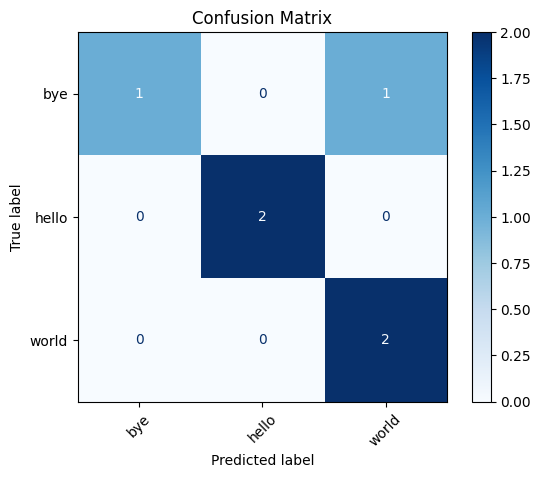

In [14]:
# confussion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Precision, Recall, F1 Score

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

         bye       1.00      0.50      0.67         2
       hello       1.00      1.00      1.00         2
       world       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



## Extract Start & End Frames Using Keypoints - NO USE

In [ ]:
# revisar estructura carpetas salida datos 

In [33]:
def extract_start_end_keypoints(data_folder, signs, output_base, frame_output_folder):
    mp_holistic = mp.solutions.holistic

    # n of keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Body + 2 hands

    for sign in signs: 
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        frame_output_folder = os.path.join(frame_output_folder, sign)
        os.makedirs(frame_output_folder, exist_ok=True)

        # Process video files
        video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]

        if not video_files:
            print("⚠️ No se encontraron archivos de video en la carpeta.")
        else:
            print(f"{len(video_files)} videos encontrados. Procesando...")

        # Function to calculate total movement between frames
        def calculate_movement(prev_kp, curr_kp):
            if prev_kp is None or curr_kp is None:
                return 0  # No movement detected if landmarks are missing

            total_movement = np.sum(np.linalg.norm(np.array(curr_kp) - np.array(prev_kp), axis=1))
            return total_movement

        # Process each video
        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"❌ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            frame_list = []
            print(f"🍓 Procesando: {video_name}")

            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                prev_keypoints = None
                start_index = None
                end_index = None
                movement_threshold = 5.0  # Adjust based on dataset (higher = less sensitive)

                frame_index = 0

                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    prev_keypoints = None
                    start_index = None
                    end_index = None
                    movement_threshold = 5.0

                    frame_index = 0

                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break

                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        results = holistic.process(frame_rgb)

                        keypoints = np.zeros((TOTAL_KEYPOINTS, 3))

                        valid_detection = False  # Track if we detected anything at all

                        if results.pose_landmarks:
                            for i, lm in enumerate(results.pose_landmarks.landmark):
                                keypoints[i] = (lm.x, lm.y, lm.z)
                            valid_detection = True

                        if results.left_hand_landmarks:
                            for i, lm in enumerate(results.left_hand_landmarks.landmark):
                                keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                            valid_detection = True

                        if results.right_hand_landmarks:
                            for i, lm in enumerate(results.right_hand_landmarks.landmark):
                                keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                            valid_detection = True

                        keypoints_list.append(keypoints)
                        frame_list.append(frame)

                        if valid_detection:
                            # Use this as fallback start if nothing else is found
                            if start_index is None:
                                start_index = frame_index

                            # Always update last valid detection
                            end_index = frame_index

                            # Optional: enhance with movement detection
                            if prev_keypoints is not None:
                                movement = calculate_movement(prev_keypoints, keypoints)
                                if movement > movement_threshold and start_index is None:
                                    start_index = frame_index
                                if movement < movement_threshold:
                                    end_index = frame_index

                            prev_keypoints = keypoints

                        frame_index += 1

                cap.release()

            # ✅ Save keypoints
            if start_index is None or end_index is None:
                print(f"⚠️ No valid keypoints detected in: {video_name}")
                
            else:
                if keypoints_list:
                    keypoints_array = np.array(keypoints_list)
                    np.save(os.path.join(output_folder, video_name.replace(".mp4", ".npy")), keypoints_array)

                # ✅ Save start & end frames
                if start_index is not None:
                    start_frame_path = os.path.join(frame_output_folder, f"{video_name}_start.jpg")
                    cv2.imwrite(start_frame_path, frame_list[start_index])
                    print(f"✅ Start frame saved: {start_frame_path}")

                if end_index is not None:
                    end_frame_path = os.path.join(frame_output_folder, f"{video_name}_end.jpg")
                    cv2.imwrite(end_frame_path, frame_list[end_index])
                    print(f"✅ End frame saved: {end_frame_path}")

        print("🎉 Proceso finalizado.")

In [ ]:
output_folder = '../data/output_frames'
frame_output_folder = '../data/start_end_frames'

os.makedirs(output_folder, exist_ok=True)

extract_start_end_keypoints('../data/', ['hello', 'bye', 'world'], output_folder, frame_output_folder)

9 videos encontrados. Procesando...
🍓 Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1742920504.000077 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920504.021052 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920504.062623 2172270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.072716 2172270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.074465 2172272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.074465 2172277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.074536 2172278 in

✅ Start frame saved: ../data/start_end_frames/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1742920504.537537 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920504.552914 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920504.588717 2172317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.598802 2172327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.599715 2172322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.599742 2172324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.599819 2172318 in

✅ Start frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_end.jpg
🍓 Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1742920505.137078 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920505.151790 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920505.191551 2172374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.202778 2172373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.203911 2172383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.205015 2172382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.205229 2172381 in

✅ Start frame saved: ../data/start_end_frames/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1742920506.051870 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920506.068290 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920506.108260 2172428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.118321 2172429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.119214 2172432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.119302 2172436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.119343 2172431 in

✅ Start frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_end.jpg
🍓 Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1742920506.515218 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920506.530464 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920506.568691 2172483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.578131 2172483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.579103 2172481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.579158 2172489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.580485 2172485 in

✅ Start frame saved: ../data/start_end_frames/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1742920506.877011 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920506.892840 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920506.931844 2172520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.941699 2172520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.942750 2172523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.942767 2172525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.942768 2172519 in

✅ Start frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1742920507.519495 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920507.533916 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920507.577558 2172595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.586420 2172608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.587608 2172593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.588648 2172599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.588716 2172601 in

✅ Start frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1742920508.676586 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920508.690264 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920508.729268 2172635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.739212 2172634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.740141 2172637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.740235 2172639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.740236 2172641 in

✅ Start frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1742920509.274557 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920509.289779 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920509.329361 2172674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.338885 2172674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.339888 2172680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.339928 2172682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.341164 2172675 in

✅ Start frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_end.jpg
🎉 Proceso finalizado.
3 videos encontrados. Procesando...
🍓 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4


I0000 00:00:1742920509.839507 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920509.854838 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920509.893069 2172715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.902616 2172721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.903621 2172713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.903633 2172721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.903667 2172714 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4


I0000 00:00:1742920510.902669 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920510.917664 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920510.956451 2172756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.965736 2172756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.966747 2172758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.966762 2172764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.967006 2172754 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4


I0000 00:00:1742920512.187492 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920512.202875 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920512.243223 2172824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.253211 2172822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.254186 2172830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.254188 2172826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.255306 2172822 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4_end.jpg
🎉 Proceso finalizado.
2 videos encontrados. Procesando...
🍓 Procesando: Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4


I0000 00:00:1742920513.051678 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920513.067003 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920513.108619 2172864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.117901 2172864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.119028 2172862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.119060 2172869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.120041 2172863 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4


I0000 00:00:1742920514.473236 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920514.488519 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920514.531077 2172906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.540167 2172905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.541230 2172905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.541257 2172904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.542521 2172910 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4_end.jpg
🎉 Proceso finalizado.


: 

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np

# paths & folders
video_folder = "../data/videos/hello"
output_folder = os.path.join(video_folder, "keypoints")
frame_output_folder = os.path.join(video_folder, "key_frames")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(frame_output_folder, exist_ok=True)

# MediaPipe setup
mp_holistic = mp.solutions.holistic

# n of keypoints
POSE_LANDMARKS = 33
HAND_LANDMARKS = 21
TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Body + 2 hands

# Process video files
video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]

if not video_files:
    print("⚠️ No se encontraron archivos de video en la carpeta.")
else:
    print(f"{len(video_files)} videos encontrados. Procesando...")

# Function to calculate total movement between frames
def calculate_movement(prev_kp, curr_kp):
    if prev_kp is None or curr_kp is None:
        return 0  # No movement detected if landmarks are missing

    total_movement = np.sum(np.linalg.norm(np.array(curr_kp) - np.array(prev_kp), axis=1))
    return total_movement

# Process each video
for video_name in video_files:
    video_path = os.path.join(video_folder, video_name)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ No se pudo abrir el video: {video_name}")
        continue

    keypoints_list = []
    frame_list = []
    print(f"🍓 Procesando: {video_name}")

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        prev_keypoints = None
        start_index = None
        end_index = None
        movement_threshold = 5.0  # Adjust based on dataset (higher = less sensitive)

        frame_index = 0

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            prev_keypoints = None
            start_index = None
            end_index = None
            movement_threshold = 5.0

            frame_index = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)

                keypoints = np.zeros((TOTAL_KEYPOINTS, 3))

                valid_detection = False  # Track if we detected anything at all

                if results.pose_landmarks:
                    for i, lm in enumerate(results.pose_landmarks.landmark):
                        keypoints[i] = (lm.x, lm.y, lm.z)
                    valid_detection = True

                if results.left_hand_landmarks:
                    for i, lm in enumerate(results.left_hand_landmarks.landmark):
                        keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                    valid_detection = True

                if results.right_hand_landmarks:
                    for i, lm in enumerate(results.right_hand_landmarks.landmark):
                        keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                    valid_detection = True

                keypoints_list.append(keypoints)
                frame_list.append(frame)

                if valid_detection:
                    # Use this as fallback start if nothing else is found
                    if start_index is None:
                        start_index = frame_index

                    # Always update last valid detection
                    end_index = frame_index

                    # Optional: enhance with movement detection
                    if prev_keypoints is not None:
                        movement = calculate_movement(prev_keypoints, keypoints)
                        if movement > movement_threshold and start_index is None:
                            start_index = frame_index
                        if movement < movement_threshold:
                            end_index = frame_index

                    prev_keypoints = keypoints

                frame_index += 1

        cap.release()

    # ✅ Save keypoints
    if start_index is None or end_index is None:
        print(f"⚠️ No valid keypoints detected in: {video_name}")
        
    else:
        if keypoints_list:
            keypoints_array = np.array(keypoints_list)
            np.save(os.path.join(output_folder, video_name.replace(".mp4", ".npy")), keypoints_array)

        # ✅ Save start & end frames
        if start_index is not None:
            start_frame_path = os.path.join(frame_output_folder, f"{video_name}_start.jpg")
            cv2.imwrite(start_frame_path, frame_list[start_index])
            print(f"✅ Start frame saved: {start_frame_path}")

        if end_index is not None:
            end_frame_path = os.path.join(frame_output_folder, f"{video_name}_end.jpg")
            cv2.imwrite(end_frame_path, frame_list[end_index])
            print(f"✅ End frame saved: {end_frame_path}")

print("🎉 Proceso finalizado.")


9 videos encontrados. Procesando...
🍓 Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1742563707.157235 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563707.172113 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563707.215994 1804888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.225405 1804883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.226496 1804893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.226570 1804884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.226570 1804883 in

✅ Start frame saved: ../data/hello/key_frames/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1742563707.685080 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563707.700396 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563707.738822 1804942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.747644 1804942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.748629 1804949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.748667 1804946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.749476 1804942 in

✅ Start frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_end.jpg
🍓 Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1742563708.272839 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563708.287480 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563708.325458 1804983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.334028 1804988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.335060 1804991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.335097 1804983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.335130 1804988 in

✅ Start frame saved: ../data/hello/key_frames/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1742563709.153944 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563709.168446 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563709.209013 1805044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.217532 1805050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.218451 1805047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.218453 1805041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.218496 1805052 in

✅ Start frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_end.jpg
🍓 Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1742563709.611910 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563709.627596 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563709.666180 1805084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.675396 1805084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.676421 1805085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.676490 1805091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.676498 1805082 in

✅ Start frame saved: ../data/hello/key_frames/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1742563709.973067 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563709.987696 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563710.025285 1805136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.034539 1805139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.035518 1805142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.035526 1805143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.035567 1805135 in

✅ Start frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1742563710.625000 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563710.639467 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563710.677411 1805191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.687602 1805198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.688712 1805196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.688769 1805194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.688771 1805189 in

✅ Start frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1742563711.814336 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563711.828574 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563711.868523 1805233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.878781 1805233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.879826 1805232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.879838 1805237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.880567 1805246 in

✅ Start frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1742563712.432207 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563712.446880 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563712.485442 1805274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.495295 1805274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.496367 1805278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.496388 1805283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.497113 1805279 in

✅ Start frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_end.jpg
🎉 Proceso finalizado.
